A comparison of the JWST 21 micron and ALMA/Phangs CO (2-1) images of NGC 628. The JWST image traces hot dust asssociated with star forming regions. The ALMA data, on the other hand, traces cool gas clouds. A comparison of images can be used to identify intert 'passive' clouds devoid of star formation. To do this properly, the images should be on the same footprint and the JWST data should be convolved to the (slightly) larger PSF of ALMA at the frequency of CO (2-1).

In [39]:
# Inputs

# JWST and phangs fits file names and directory paths
dir_jwst = '/home/mtr/Downloads/fits/'
dir_phangs = '/home/mtr/Downloads/fits/'
image_file_jwst = 'jw02107-o039_t018_miri_f2100w_i2d.fits'
image_file_phangs = 'ngc0628_12m+7m+tp_co21_broad_mom0.fits'

# Galaxy parameters
galaxy_distance_mpc = 9.5  # Distance to NGC 628 in Mpc

# Values below for convolving JWST data to MIPS resolution
# FWHM of PSFs
jwst_fwhm = 0.67  # JWST MIRI F2100W PSF FWHM (It is not given in the header so specified here)

# Plot parameters
xsize = 15 
ysize = 12

In [40]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from astropy.wcs import WCS
#from astropy.stats import sigma_clipped_stats
from reproject import reproject_interp
from astropy.convolution import Gaussian2DKernel, convolve_fft
from matplotlib import patches
from matplotlib import gridspec
from matplotlib.colors import Normalize
from scipy import ndimage
from astropy.visualization import MinMaxInterval, AsinhStretch, ImageNormalize

Plotting routine for referencing. A scale and north arrow can be included on the output image

In [41]:
def display_image_data(image_data, xsize, ysize, flux_min, flux_max, show_north_arrow=False, show_scale_bar=False, pixel_scale=None, galaxy_distance_mpc=None):
    plt.figure(figsize=(xsize,ysize))
    plt.gcf().set_facecolor("black")
    plt.imshow(image_data, cmap='gist_heat', vmin=flux_min, vmax=flux_max)
    plt.axis('off')

        # Add North arrow if requested
    if show_north_arrow:
        # Arrow position (adjust as needed)
        arrow_x = 0.9  # Position from right (0.9 means 90% from left)
        arrow_y = 0.1  # Position from bottom (0.1 means 10% from bottom)
        arrow_length = 0.1  # Length of the arrow
    
        ax = plt.gca()
        ax.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                    xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                    arrowprops=dict(facecolor='white', width=2, headwidth=8, headlength=10),
                    color='white', fontsize=14, ha='center', va='bottom')
    
  # Add scale bar if requested
    if show_scale_bar and pixel_scale is not None and galaxy_distance_mpc is not None:
        
        kpc_in_arcsec = 1.0e-3 * (1.0 / galaxy_distance_mpc) * 206265 
        
        kpc_in_pixels = kpc_in_arcsec / pixel_scale
        
        # Scale bar position and properties
        bar_length = kpc_in_pixels  # Length in pixels for 1 kpc
        bar_x = 0.05 * image_data.shape[1]  # X position (10% from left edge)
        bar_y = 0.1 * image_data.shape[0]  # Y position (10% from bottom)
        bar_height = image_data.shape[0] * 0.005  # Height of the bar (0.5% of image height)
        
        rect = patches.Rectangle((bar_x, bar_y), bar_length, bar_height, 
                                linewidth=1, edgecolor='white', facecolor='white')
        ax.add_patch(rect)
    
        plt.text(bar_x + bar_length/2, bar_y - 3*bar_height, '1 kpc', 
                color='white', fontsize=12, ha='center', va='bottom')

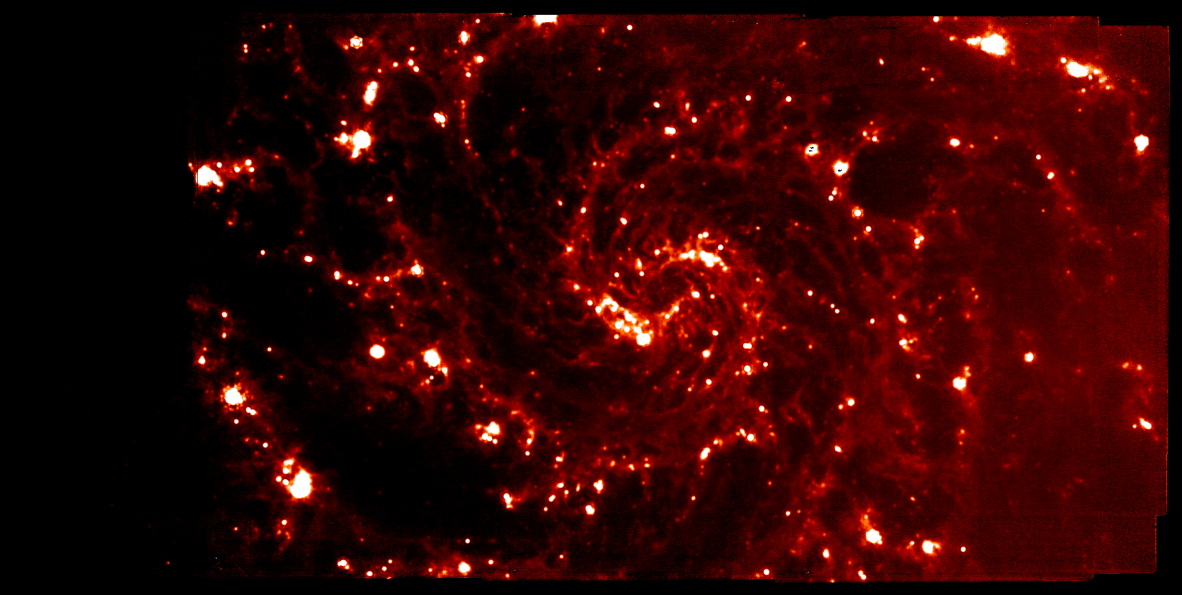

In [42]:
# Read JWST data and header
hdu_list = fits.open(dir_jwst + image_file_jwst)

image_data_jwst = hdu_list[1].data
image_header_jwst = hdu_list[1].header

flux_min = 275
flux_max = 285

display_image_data(image_data_jwst,xsize,ysize,flux_min,flux_max)

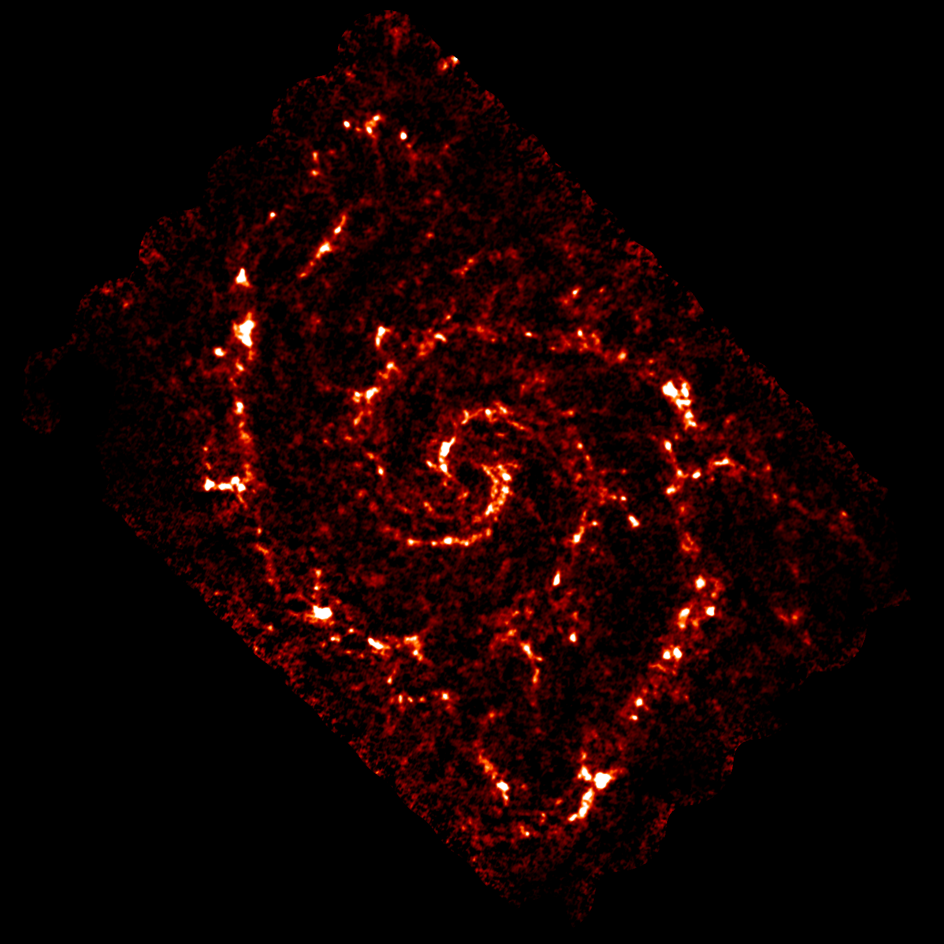

In [43]:
# Read PHANGS data and header
hdu_list = fits.open(dir_phangs + image_file_phangs)
image_data_phangs = hdu_list[0].data
image_header_phangs= hdu_list[0].header

flux_min = 0
flux_max = 20

display_image_data(image_data_phangs,xsize,ysize,flux_min,flux_max)

In [44]:
# Get theT pixel scales from the header
cdelt_phangs = np.abs(image_header_phangs['CDELT1']) # pixel scale in degrees

phangs_pixscale = cdelt_phangs * 3600  # arcsecs

cdelt_jwst = np.abs(image_header_jwst['CDELT1']) # pixel scale in degrees

jwst_pixscale = cdelt_jwst * 3600  # arcsecs

Place the JWST and PHANGS on the same footprint 

In [45]:
# Create a new HDU with the JWST  data and its original header
jwst_hdu = fits.PrimaryHDU(data=image_data_jwst, header=image_header_jwst)
jwst_hdul = fits.HDUList([jwst_hdu])

Set DATE-AVG to '2022-07-17T12:34:31.886' from MJD-AVG.
Set DATE-END to '2022-07-17T13:29:16.222' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -37.743685 from OBSGEO-[XYZ].
Set OBSGEO-H to 1738706589.006 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


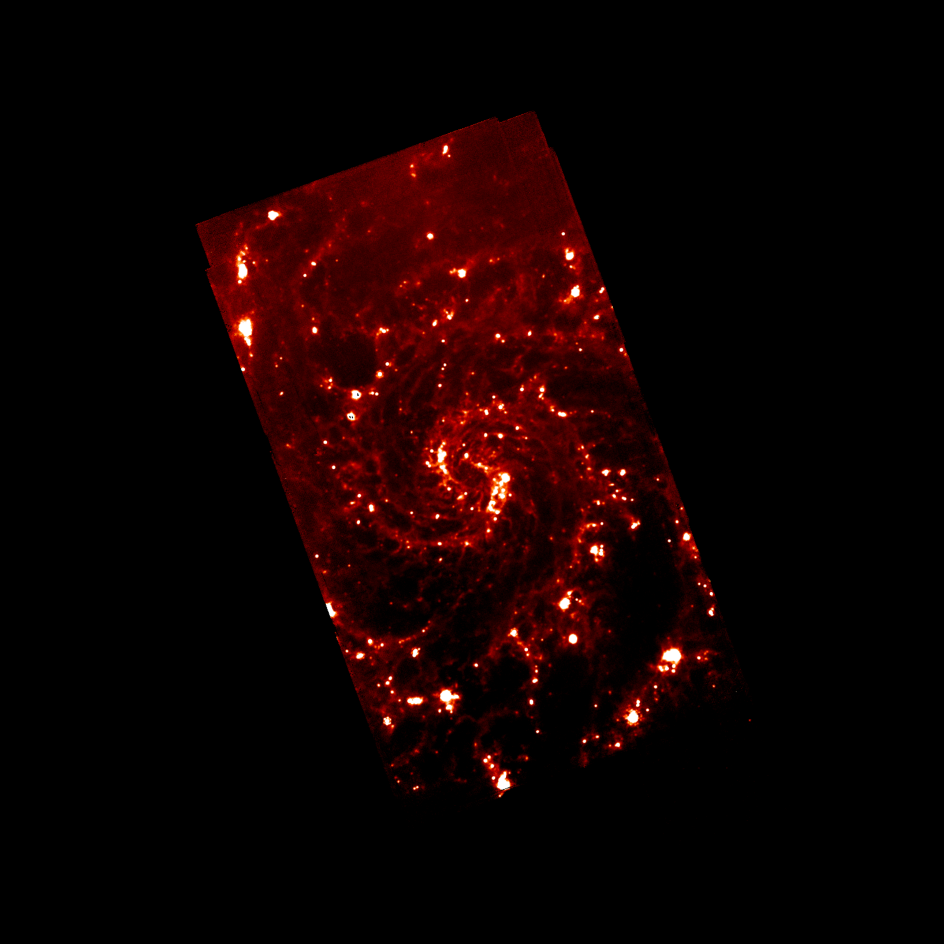

In [46]:
# Project the JWST data onto the PHANGS footprint
reprojected_jwst, footprint = reproject_interp(jwst_hdul, image_header_phangs)

flux_min = 275
flux_max = 285
display_image_data(reprojected_jwst,xsize,ysize,flux_min,flux_max)

In [47]:
# Create a mask of NaN and 0 values in JWST data 
# (this will ensure the PHANGS and JWST data have the same pixels of NaN and zero values).
jwst_nan_mask = np.isnan(reprojected_jwst) 
jwst_zero_mask = reprojected_jwst == 0

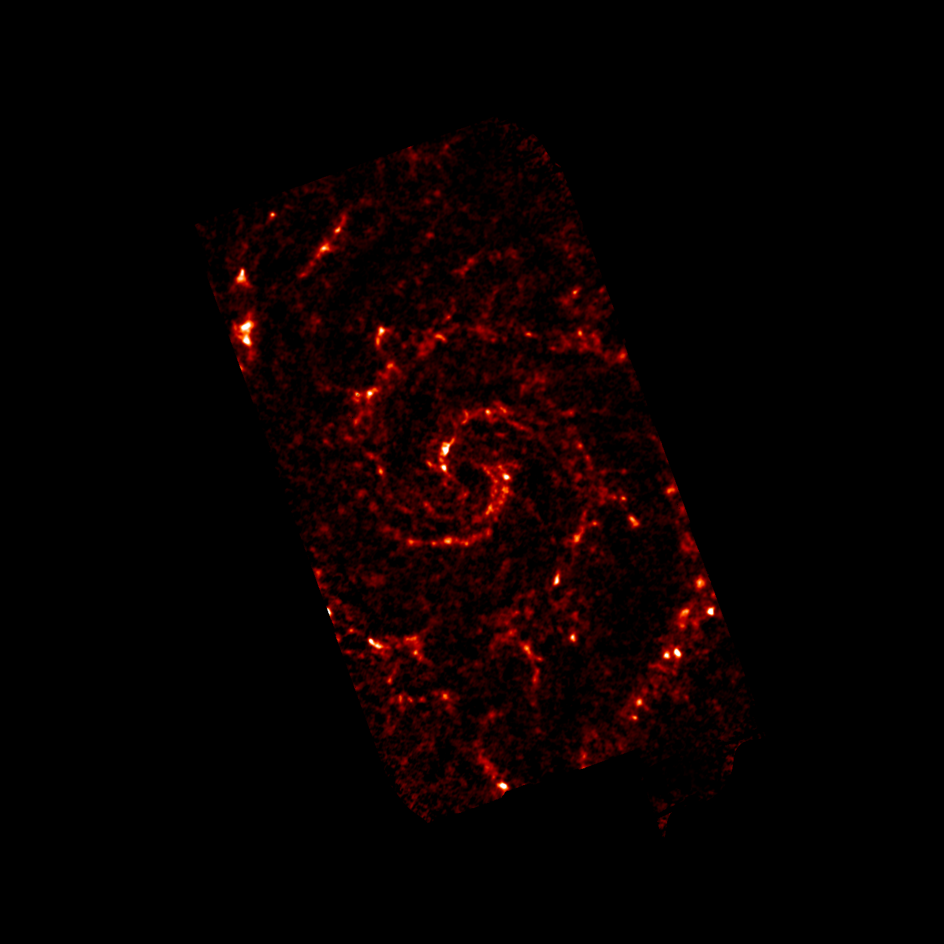

In [48]:
# Apply masks to the PHANGS data
image_data_phangs[jwst_nan_mask] = np.nan 
image_data_phangs[jwst_zero_mask] = 0

flux_min = 0
flux_max = 30
display_image_data(image_data_phangs,xsize,ysize,flux_min,flux_max)

Convolving JWST data to the resolution of the PHANGS data 

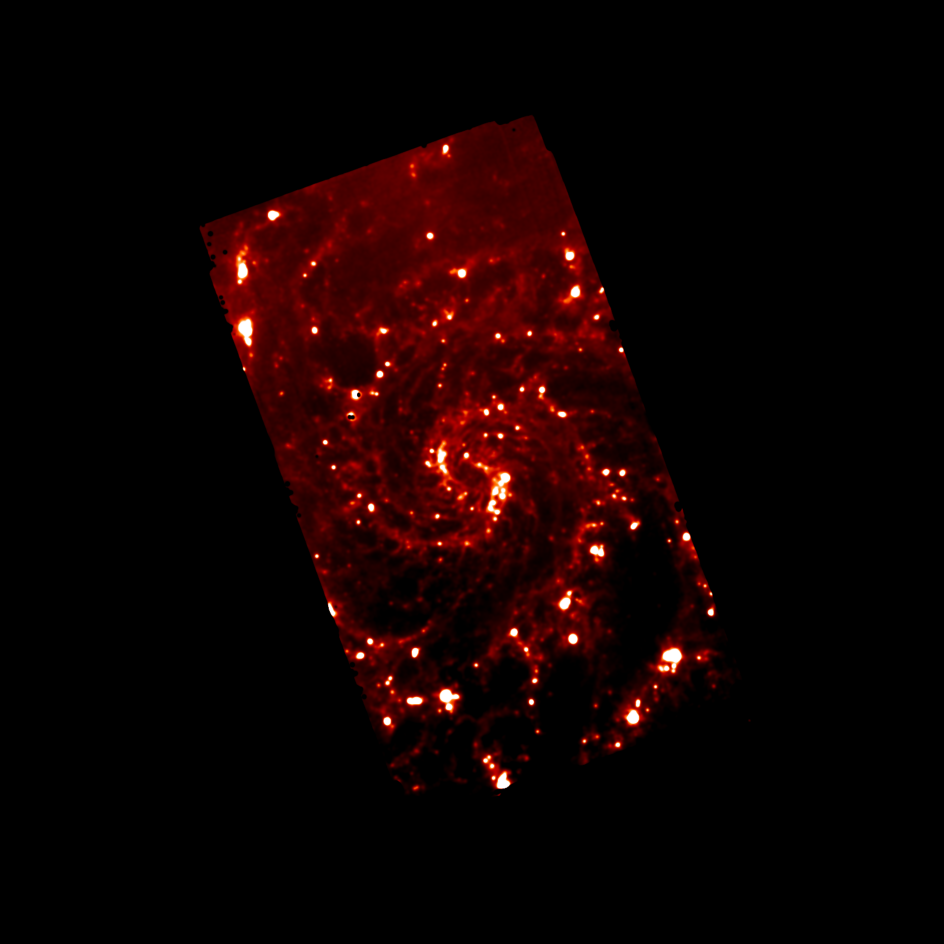

In [49]:
phangs_fwhm = np.abs(image_header_phangs['BMIN']) * 3600 # Resolution of PHANGS data in arcsecs
phangs_fwhm_pixscale = phangs_fwhm / phangs_pixscale
jwst_fwhm_pixscale = jwst_fwhm / jwst_pixscale


# Calculate the required sigma for the kernel (in JWST pixels)
target_fwhm = np.sqrt(phangs_fwhm**2 - jwst_fwhm**2) 
sigma_pix = target_fwhm / 2.355 / phangs_pixscale


# Create a Gaussian kernel
kernel = Gaussian2DKernel(x_stddev=sigma_pix)

# Convolve JWST data
jwst_convolved = convolve_fft(reprojected_jwst, kernel, fill_value=0, normalize_kernel=True, allow_huge=True, nan_treatment='fill')

flux_min = 275
flux_max = 285

display_image_data(jwst_convolved,xsize,ysize,flux_min,flux_max)

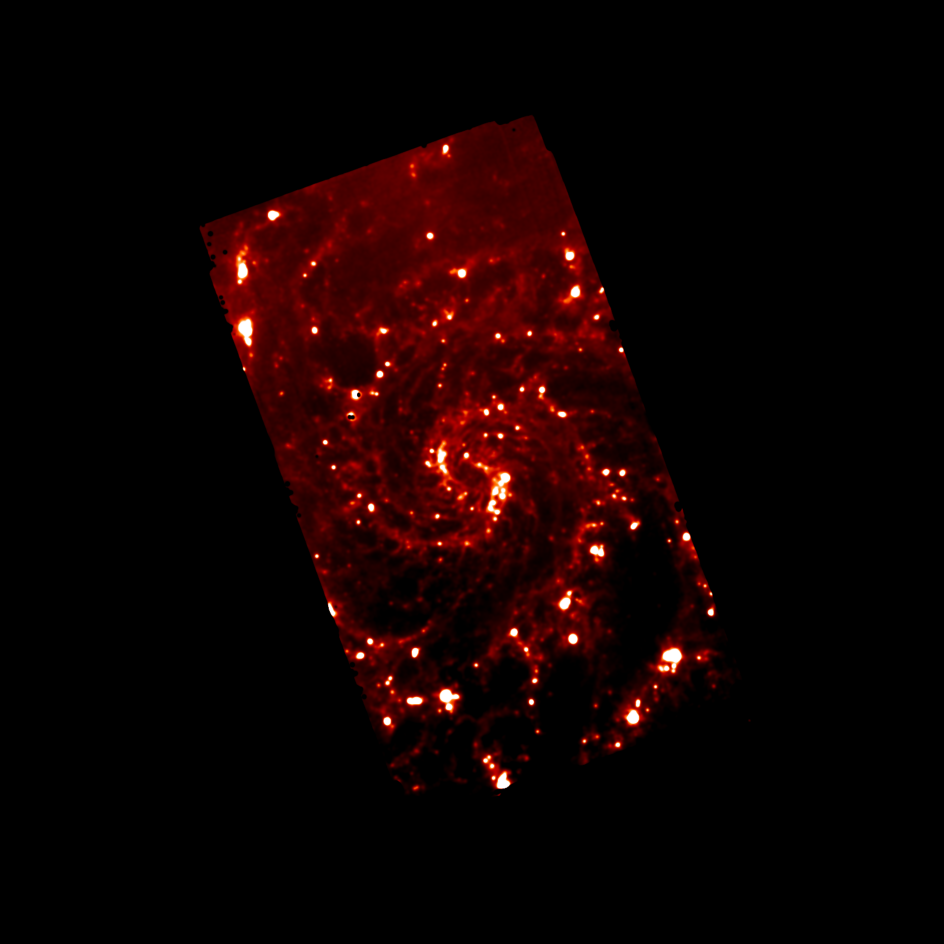

In [50]:
# Re-apply the NaN mask
jwst_convolved[jwst_nan_mask] = np.nan 
jwst_convolved[jwst_zero_mask] = 0 


display_image_data(jwst_convolved,xsize,ysize,flux_min,flux_max)

In [51]:
def display_two_images(image_data1, image_data2, xsize, ysize, 
                       flux_min1, flux_max1, flux_min2, flux_max2, 
                       show_north_arrow1=False, show_north_arrow2=False,
                       show_scale_bar1=False, show_scale_bar2=False,
                       pixel_scale1=None, pixel_scale2=None,
                       galaxy_distance_mpc1=None, galaxy_distance_mpc2=None,
                       titles=None):
    """
    Display two images side by side with north arrow, and scale bar.
    
    Parameters:
    - image_data1, image_data2: Input image arrays
    - xsize, ysize: Figure size
    - flux_min/max: Color scaling parameters for each image
    - show_north_arrow: Whether to display north arrow
    - show_scale_bar: Whether to display scale bar
    - pixel_scale: Pixel scale for scale bar
    - galaxy_distance_mpc: Galaxy distance for scale bar
    - titles: Optional list of two titles for the images
    """
    # Create a figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(xsize*2, ysize))
    fig.patch.set_facecolor("black")
    
    
    # Display first image
    ax1.imshow(image_data1, cmap='gist_heat', vmin=flux_min1, vmax=flux_max1)
    ax1.axis('off')
    
    # Display second image
    ax2.imshow(image_data2, cmap='magma', vmin=flux_min2, vmax=flux_max2)
    ax2.axis('off')
    
    # Add titles if provided
    if titles:
        ax1.set_title(titles[0], color='white', fontsize=30)
        ax2.set_title(titles[1], color='white', fontsize=30)
    
    # Add North arrow to first image
    if show_north_arrow1:
        arrow_x, arrow_y = 0.9, 0.1
        arrow_length = 0.15
        ax1.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                     xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                     arrowprops=dict(facecolor='white', width=4, headwidth=16, headlength=16),
                     color='white', fontsize=25, ha='center', va='bottom')
    
    # Add North arrow to second image
    if show_north_arrow2:
        arrow_x, arrow_y = 0.9, 0.1
        arrow_length = 0.15
        ax2.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                     xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                     arrowprops=dict(facecolor='white', width=4, headwidth=16, headlength=16),
                     color='white', fontsize=25, ha='center', va='bottom')
    
    # Add scale bar to first image
    if show_scale_bar1 and pixel_scale1 is not None and galaxy_distance_mpc1 is not None:
        kpc_in_arcsec = 1.0e-3 * (1.0 / galaxy_distance_mpc1) * 206265
        kpc_in_pixels = kpc_in_arcsec / pixel_scale1
        
        bar_length = kpc_in_pixels
        bar_x = 0.1 * image_data1.shape[1]
        bar_y = 0.1 * image_data1.shape[0]
        bar_height = image_data1.shape[0] * 0.005
        
        rect = patches.Rectangle((bar_x, bar_y), bar_length, bar_height,
                                 linewidth=1, edgecolor='white', facecolor='white')
        ax1.add_patch(rect)
        
        ax1.text(bar_x + bar_length/2, bar_y - 2*bar_height, '1 kpc',
                 color='white', fontsize=25, ha='center', va='bottom')
    
    # Add scale bar to second image
    if show_scale_bar2 and pixel_scale2 is not None and galaxy_distance_mpc2 is not None:
        kpc_in_arcsec = 1.0e-3 * (1.0 / galaxy_distance_mpc2) * 206265
        kpc_in_pixels = kpc_in_arcsec / pixel_scale2
        
        bar_length = kpc_in_pixels
        bar_x = 0.1 * image_data2.shape[1]
        bar_y = 0.1 * image_data2.shape[0]
        bar_height = image_data2.shape[0] * 0.005
        
        rect = patches.Rectangle((bar_x, bar_y), bar_length, bar_height,
                                 linewidth=1, edgecolor='white', facecolor='white')
        ax2.add_patch(rect)
        
        ax2.text(bar_x + bar_length/2, bar_y - 2*bar_height, '1 kpc',
                 color='white', fontsize=25, ha='center', va='bottom')
    
    plt.show()

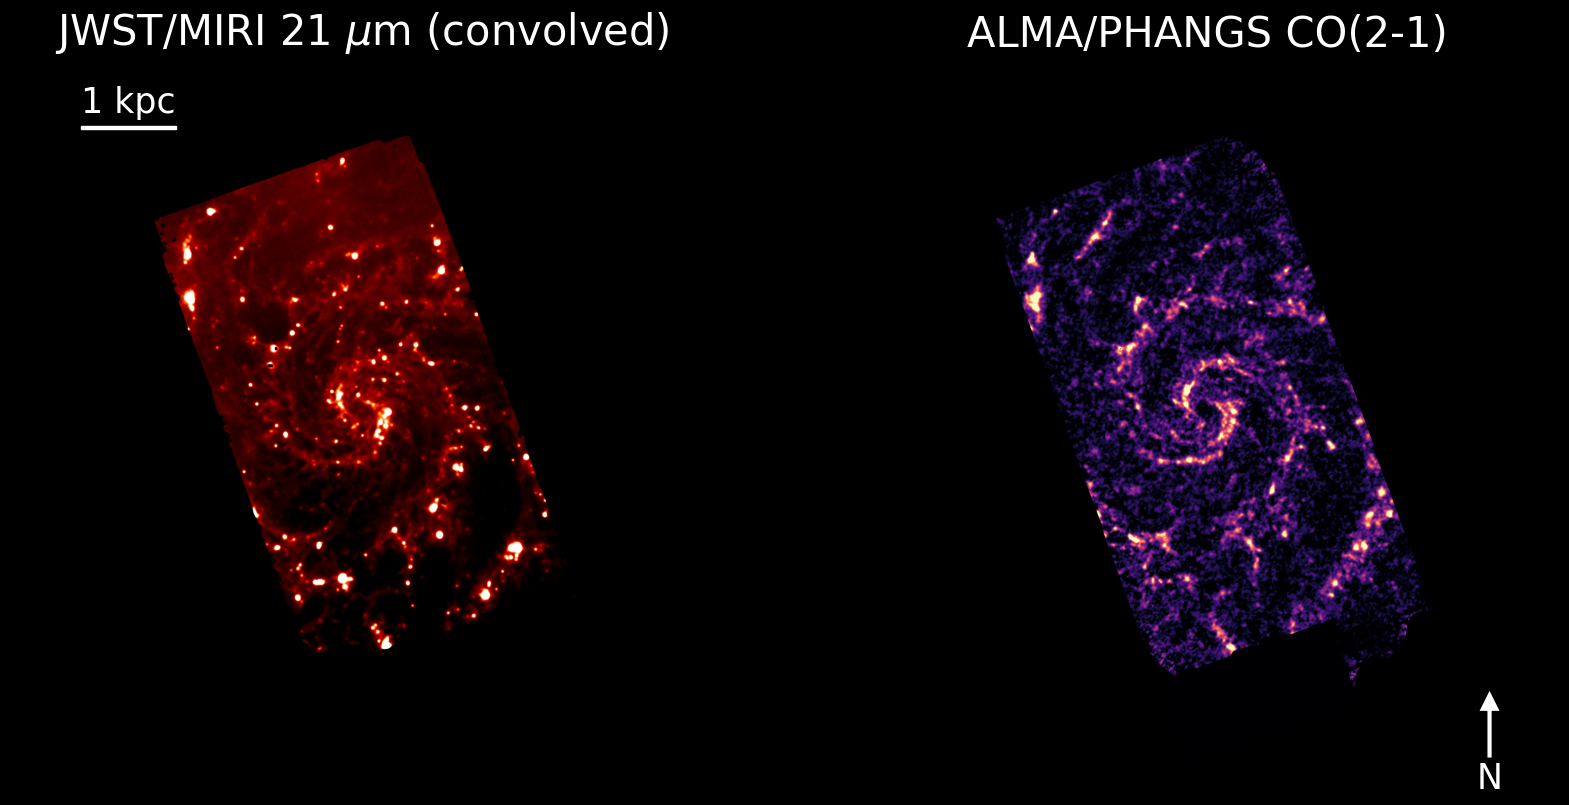

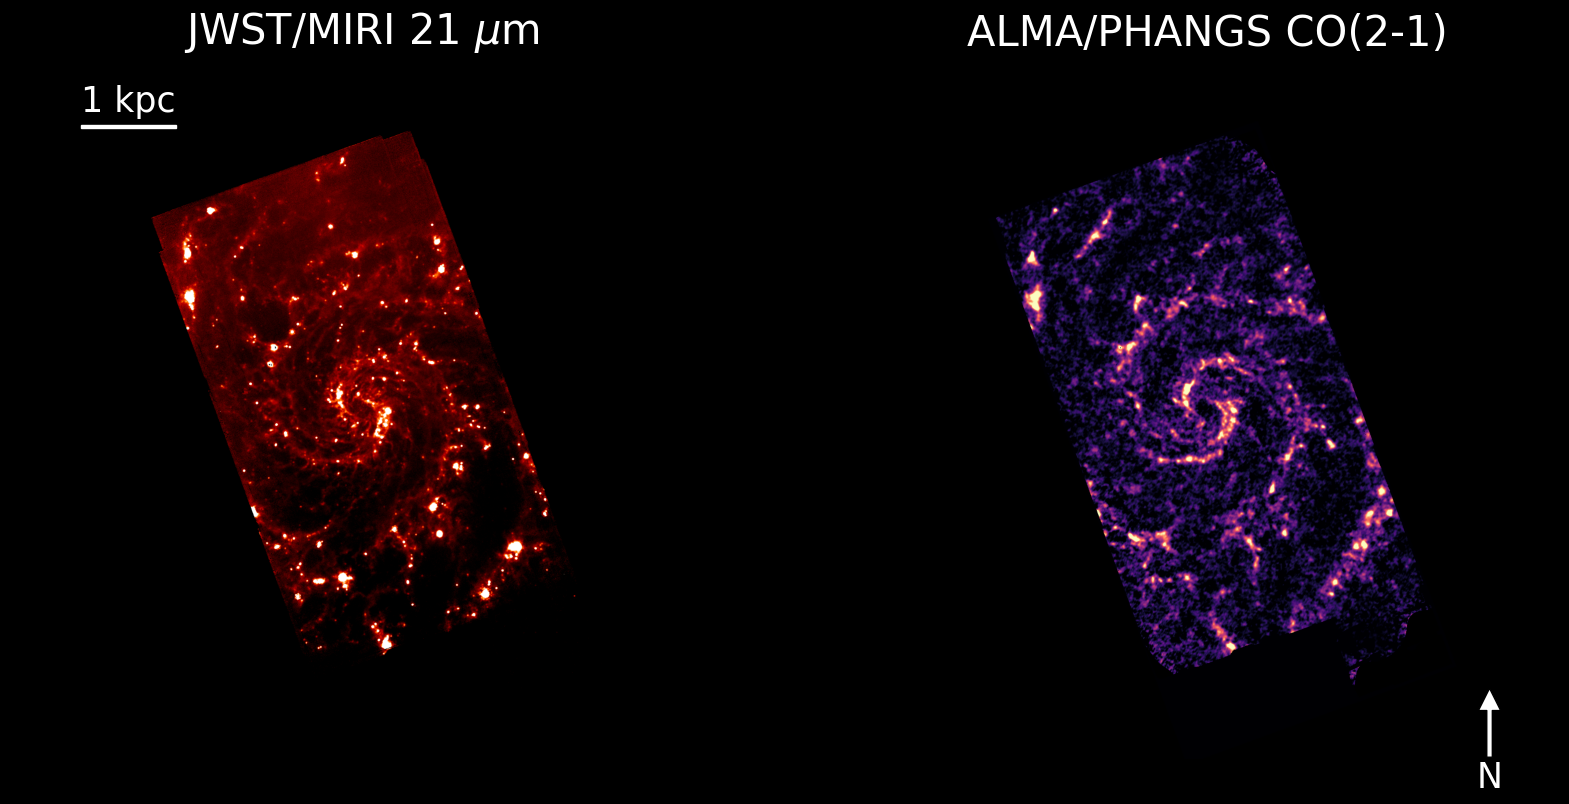

In [52]:
display_two_images(
    jwst_convolved, image_data_phangs,  # Your two image arrays
    xsize=10, ysize=10,        # Figure size
    flux_min1=275, flux_max1=285,  # Color scaling for first image
    flux_min2=0, flux_max2=20,  # Color scaling for second image
    show_north_arrow1=False,    # Show north arrow on first image
    show_north_arrow2=True,    # Show north arrow on second image
    show_scale_bar1=True,      # Show scale bar on first image
    show_scale_bar2=False,      # Show scale bar on second image
    pixel_scale1=0.1,          # Pixel scale for first image
    pixel_scale2=0.1,          # Pixel scale for second image
    galaxy_distance_mpc1=galaxy_distance_mpc,  # Galaxy distance for first image
    galaxy_distance_mpc2=galaxy_distance_mpc,  # Galaxy distance for second image
    titles=['JWST/MIRI 21 $\mu$m (convolved)', 'ALMA/PHANGS CO(2-1)']  # Optional titles
)
# display again with unconvolved jwst
display_two_images(
    reprojected_jwst, image_data_phangs,  # Your two image arrays
    xsize=10, ysize=10,        # Figure size
    flux_min1=275, flux_max1=285,  # Color scaling for first image
    flux_min2=0, flux_max2=20,  # Color scaling for second image
    show_north_arrow1=False,    # Show north arrow on first image
    show_north_arrow2=True,    # Show north arrow on second image
    show_scale_bar1=True,      # Show scale bar on first image
    show_scale_bar2=False,      # Show scale bar on second image
    pixel_scale1=0.1,          # Pixel scale for first image
    pixel_scale2=0.1,          # Pixel scale for second image
    galaxy_distance_mpc1=galaxy_distance_mpc,  # Galaxy distance for first image
    galaxy_distance_mpc2=galaxy_distance_mpc,  # Galaxy distance for second image
    titles=['JWST/MIRI 21 $\mu$m', 'ALMA/PHANGS CO(2-1)']  # Optional titles
)

Reduce the space between the images by overlapping the PHANGS and JWST plots.

In [53]:
def add_circle_to_axis(ax, x, y, radius=1.0):
    """
    Add a small white circle to a matplotlib axis.
    
    Args:
        ax: Matplotlib axis
        x, y: Coordinates for circle center
        radius: Radius of the circle (in data units)
    """
    circle = patches.Circle((x, y), radius=radius, 
                            facecolor='none', 
                            edgecolor='white', 
                            linewidth=2,
                            alpha=1.0)
    ax.add_patch(circle)

def display_two_overlap_images(image_data1, image_data2, xsize, ysize, 
                       flux_min1, flux_max1, flux_min2, flux_max2, 
                       show_north_arrow1=False, show_north_arrow2=False,
                       show_scale_bar1=False, show_scale_bar2=False,
                       pixel_scale1=None, pixel_scale2=None,
                       galaxy_distance_mpc1=None, galaxy_distance_mpc2=None,
                       titles=None,
                       overlap_fraction=0.1):  # New parameter to control overlap amount
    """
    Display two images side by side with north arrow, scale bar, and overlap.
    
    Parameters:
    - image_data1, image_data2: Input image arrays
    - xsize, ysize: Figure size
    - flux_min/max: Color scaling parameters for each image
    - show_north_arrow: Whether to display north arrow
    - show_scale_bar: Whether to display scale bar
    - pixel_scale: Pixel scale for scale bar
    - galaxy_distance_mpc: Galaxy distance for scale bar
    - titles: Optional list of two titles for the images
    - overlap_fraction: How much the second image should overlap the first (0-1)
    """
    
    # Create figure
    fig = plt.figure(figsize=(xsize*2, ysize))
    fig.patch.set_facecolor("black")
    
    # Create custom grid with overlap
    gs = gridspec.GridSpec(1, 2)
    
    # Calculate position for second subplot to create overlap
    # Default position would be [0, 0, 0.5, 1] for left plot and [0.5, 0, 0.5, 1] for right plot
    # We'll adjust the starting position of the second plot to be less than 0.5
    left_plot_width = 0.5 + overlap_fraction/2
    right_plot_start = 0.5 - overlap_fraction/2
    
    # Create axes with custom positions
    ax1 = plt.subplot(gs[0, 0])
    ax1.set_position([0, 0, left_plot_width, 1])
    
    ax2 = plt.subplot(gs[0, 1])
    ax2.set_position([right_plot_start, 0, 0.5 + overlap_fraction/2, 1])
    
    # Display first image
    ax1.imshow(image_data1, cmap='gist_heat', vmin=flux_min1, vmax=flux_max1)
    ax1.axis('off')
    
    # Display second image
    ax2.imshow(image_data2, cmap='magma', vmin=flux_min2, vmax=flux_max2)
    ax2.axis('off')
    
    # Add titles if provided
    if titles:
        ax1.set_title(titles[0], color='white', fontsize=30)
        ax2.set_title(titles[1], color='white', fontsize=30)
    
    # Add North arrow to first image
    if show_north_arrow1:
        arrow_x, arrow_y = 0.1, 0.2
        arrow_length = 0.15
        ax1.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                     xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                     arrowprops=dict(facecolor='white', width=4, headwidth=16, headlength=16),
                     color='white', fontsize=25, ha='center', va='bottom')
    
    # Add North arrow to second image
    if show_north_arrow2:
        arrow_x, arrow_y = 0.9, 0.15
        arrow_length = 0.15
        ax2.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                     xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                     arrowprops=dict(facecolor='white', width=4, headwidth=16, headlength=16),
                     color='white', fontsize=25, ha='center', va='bottom')
    
    # Add scale bar to first image
    if show_scale_bar1 and pixel_scale1 is not None and galaxy_distance_mpc1 is not None:
        kpc_in_arcsec = 1.0e-3 * (1.0 / galaxy_distance_mpc1) * 206265
        kpc_in_pixels = kpc_in_arcsec / pixel_scale1
        
        bar_length = kpc_in_pixels
        bar_x = 0.1 * image_data1.shape[1]
        bar_y = 0.1 * image_data1.shape[0]
        bar_height = image_data1.shape[0] * 0.005
        
        rect = patches.Rectangle((bar_x, bar_y), bar_length, bar_height,
                                 linewidth=1, edgecolor='white', facecolor='white')
        ax1.add_patch(rect)
        
        ax1.text(bar_x + bar_length/2, bar_y - 2*bar_height, '1 kpc',
                 color='white', fontsize=25, ha='center', va='bottom')
    
    # Add scale bar to second image
    if show_scale_bar2 and pixel_scale2 is not None and galaxy_distance_mpc2 is not None:
        kpc_in_arcsec = 1.0e-3 * (1.0 / galaxy_distance_mpc2) * 206265
        kpc_in_pixels = kpc_in_arcsec / pixel_scale2
        
        bar_length = kpc_in_pixels
        bar_x = 0.1 * image_data2.shape[1]
        bar_y = 0.1 * image_data2.shape[0]
        bar_height = image_data2.shape[0] * 0.005
        
        rect = patches.Rectangle((bar_x, bar_y), bar_length, bar_height,
                                 linewidth=1, edgecolor='white', facecolor='white')
        ax2.add_patch(rect)
        
        ax2.text(bar_x + bar_length/2, bar_y - 2*bar_height, '1 kpc',
                 color='white', fontsize=25, ha='center', va='bottom')
    # Add circles representing PSFs
    add_circle_to_axis(ax1, x=600, y=1450, radius=jwst_fwhm_pixscale)
    add_circle_to_axis(ax2, x=600, y=1450, radius=phangs_fwhm_pixscale)
    ax1.text(600-85, 1450, 'PSF',
                 color='white', fontsize=25, ha='center', va='center')
    #ax2.text(600, 1450-20, 'PSF',
    #             color='white', fontsize=25, ha='center', va='bottom')
    
    plt.show()

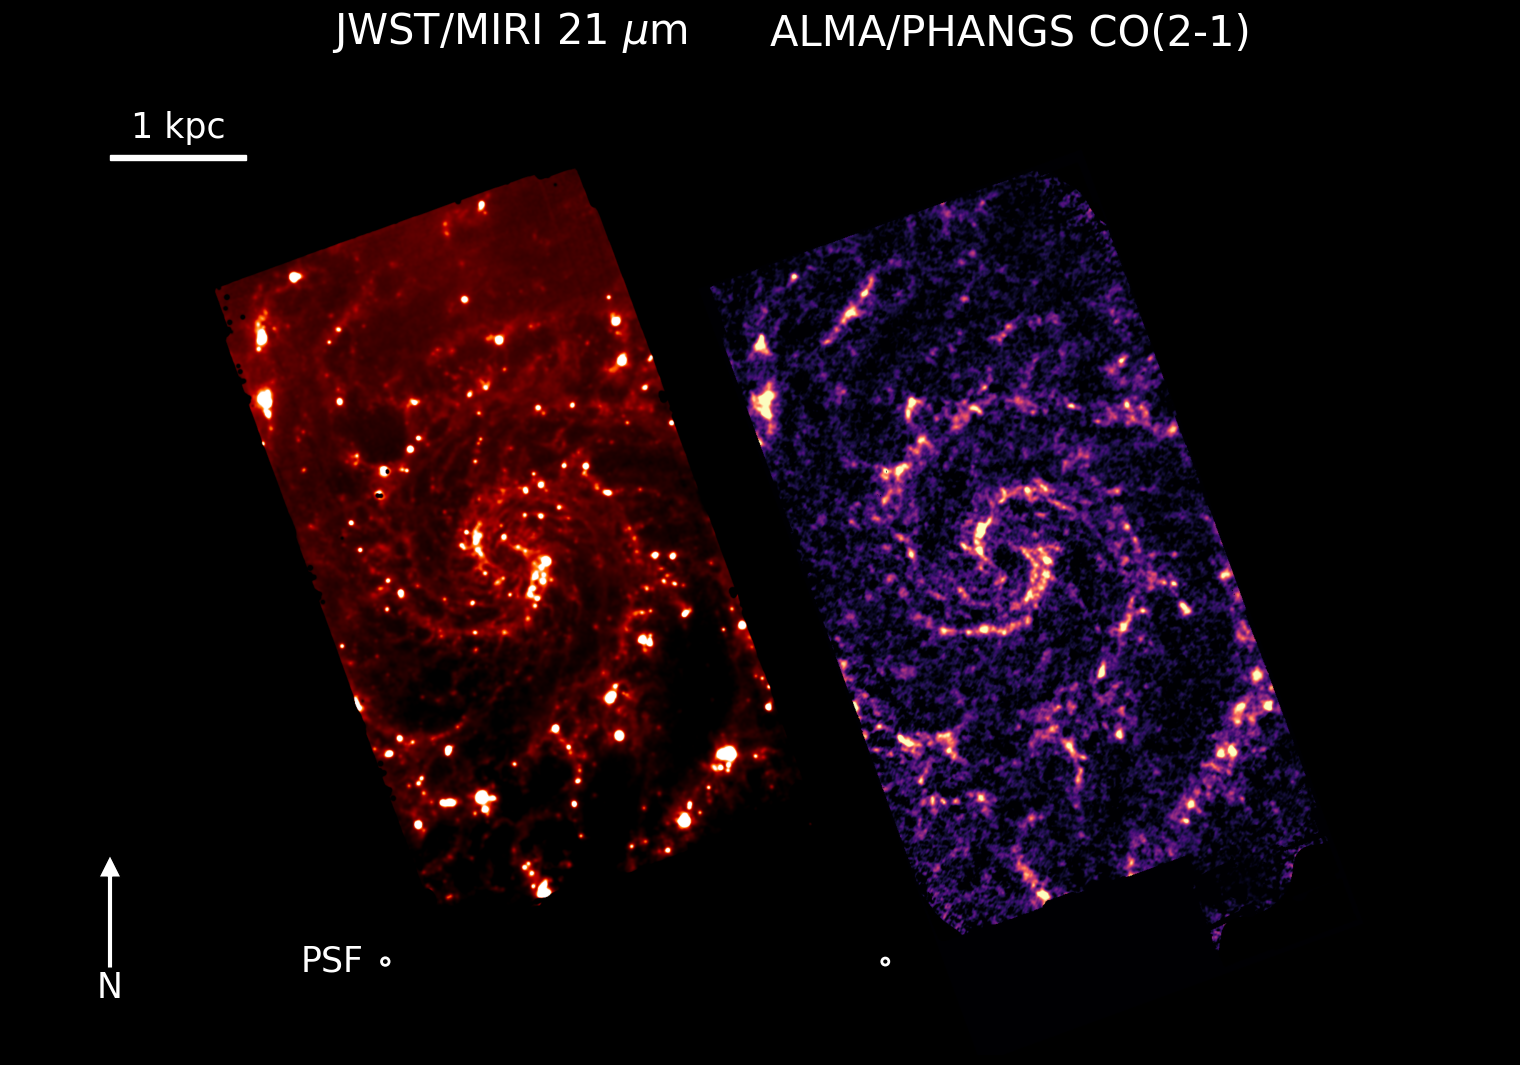

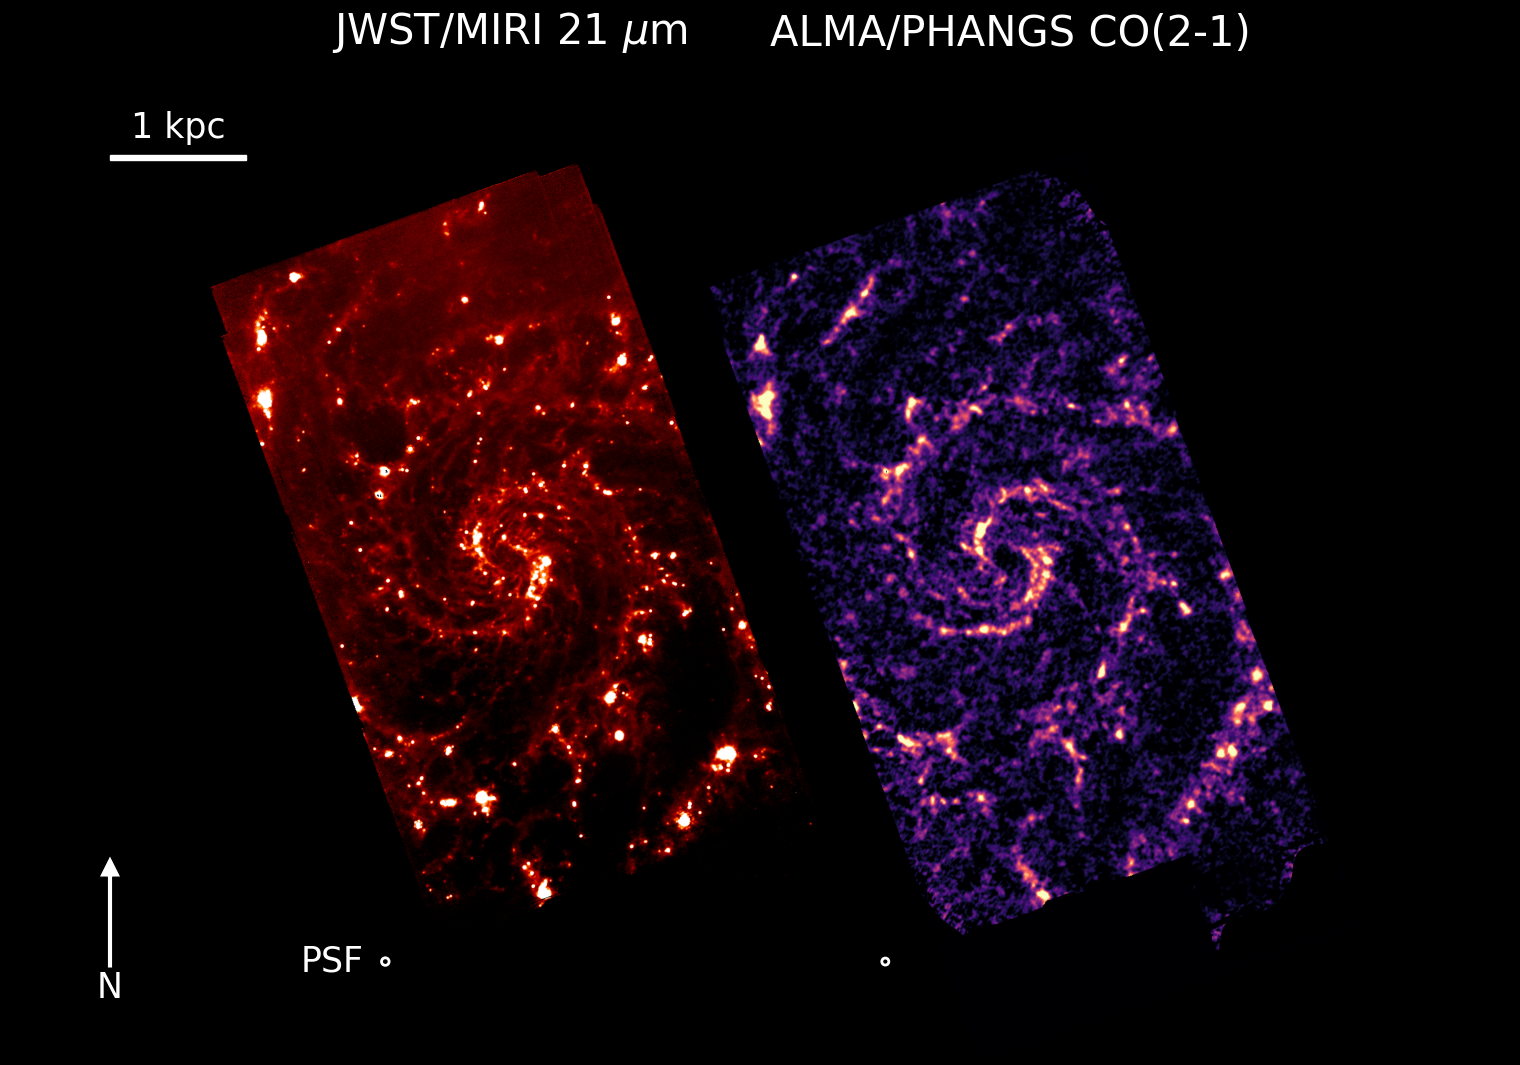

In [54]:
display_two_overlap_images(
    jwst_convolved, image_data_phangs,  # Your two image arrays
    xsize=10, ysize=10,        # Figure size
    flux_min1=275, flux_max1=285,  # Color scaling for first image
    flux_min2=0, flux_max2=20,  # Color scaling for second image
    show_north_arrow1=True,    # Show north arrow on first image
    show_north_arrow2=False,    # Show north arrow on second image
    show_scale_bar1=True,      # Show scale bar on first image
    show_scale_bar2=False,      # Show scale bar on second image
    pixel_scale1=0.1,          # Pixel scale for first image
    pixel_scale2=0.1,          # Pixel scale for second image
    galaxy_distance_mpc1=galaxy_distance_mpc,  # Galaxy distance for first image
    galaxy_distance_mpc2=galaxy_distance_mpc,  # Galaxy distance for second image
    titles=['JWST/MIRI 21 $\mu$m', 'ALMA/PHANGS CO(2-1)'],  # Optional titles
    overlap_fraction = 0.5
)
# display again with unconvolved jwst
display_two_overlap_images(
    reprojected_jwst, image_data_phangs,  # Your two image arrays
    xsize=10, ysize=10,        # Figure size
    flux_min1=275, flux_max1=285,  # Color scaling for first image
    flux_min2=0, flux_max2=20,  # Color scaling for second image
    show_north_arrow1=True,    # Show north arrow on first image
    show_north_arrow2=False,    # Show north arrow on second image
    show_scale_bar1=True,      # Show scale bar on first image
    show_scale_bar2=False,      # Show scale bar on second image
    pixel_scale1=0.1,          # Pixel scale for first image
    pixel_scale2=0.1,          # Pixel scale for second image
    galaxy_distance_mpc1=galaxy_distance_mpc,  # Galaxy distance for first image
    galaxy_distance_mpc2=galaxy_distance_mpc,  # Galaxy distance for second image
    titles=['JWST/MIRI 21 $\mu$m', 'ALMA/PHANGS CO(2-1)'],  # Optional titles
    overlap_fraction = 0.5
)

In [83]:
def overlay_fits_images(data1, data2,
                        figsize=(10, 8), clip_percentile=99.5,
                        vmin1=None, vmax1=None, vmin2=None, vmax2=None,
                        color1='red', color2='cyan', title=None, label1=None, label2=None, label3=None):
    
    # Create figure with black background
    fig = plt.figure(figsize=figsize, facecolor='black')
    ax = fig.add_subplot(111)
    ax.set_facecolor('black')
    
    if vmax1 is None:
        vmax1 = np.percentile(data1, clip_percentile)
    if vmax2 is None:
        vmax2 = np.percentile(data2, clip_percentile)
    
    if vmin1 is None:
        vmin1 = 0
    if vmin2 is None:
        vmin2 = 0
  
    norm1 = Normalize(vmin=vmin1, vmax=vmax1)
    norm2 = Normalize(vmin=vmin2, vmax=vmax2)
      
    # Normalize the data
    norm_data1 = norm1(data1)
    norm_data2 = norm2(data2)
    
    # Create RGB image
    rgb = np.zeros((data1.shape[0], data1.shape[1], 3))
    
    # Assign each image to different color channels
    if color1 == 'red':
        rgb[:, :, 0] = norm_data1
    elif color1 == 'green':
        rgb[:, :, 1] = norm_data1
    elif color1 == 'blue':
        rgb[:, :, 2] = norm_data1
    elif color1 == 'cyan':
        rgb[:, :, 1] = norm_data1
        rgb[:, :, 2] = norm_data1
    elif color1 == 'magenta':
        rgb[:, :, 0] = norm_data1
        rgb[:, :, 2] = norm_data1
    elif color1 == 'yellow':
        rgb[:, :, 0] = norm_data1
        rgb[:, :, 1] = norm_data1
        
    if color2 == 'red':
        rgb[:, :, 0] = norm_data2
    elif color2 == 'green':
        rgb[:, :, 1] = norm_data2
    elif color2 == 'blue':
        rgb[:, :, 2] = norm_data2
    elif color2 == 'cyan':
        rgb[:, :, 1] = norm_data2
        rgb[:, :, 2] = norm_data2
    elif color2 == 'magenta':
        rgb[:, :, 0] = norm_data2
        rgb[:, :, 2] = norm_data2
    elif color2 == 'yellow':
        rgb[:, :, 0] = norm_data2
        rgb[:, :, 1] = norm_data2
    
    # Display the RGB image
    ax.imshow(rgb, origin='upper')
    
    # Set text and spine colors to white for better visibility on black background
    ax.xaxis.label.set_color('white')
    ax.yaxis.label.set_color('white')
    if title:
        ax.set_title(title, color='white')
    
    # Set spine colors to black to hide them
    for spine in ax.spines.values():
        spine.set_color('black')
        
    ax.plot([0], [0], color=color1, linewidth=5, label=label1)
    ax.plot([0], [0], color=color2, linewidth=5, label=label2)
    ax.plot([0], [0], color='white', linewidth=5, label=label3)
    
    # Configure legend with white text
    legend = ax.legend(loc='upper right')
    frame = legend.get_frame()
    frame.set_facecolor('black')
    frame.set_edgecolor('black')
    
    # Set legend text color to white
    for text in legend.get_texts():
        text.set_color('white')
    
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Make sure the figure has tight layout
    plt.tight_layout()
    plt.savefig('JWST_PHANGS_Overlay.png', facecolor='black', bbox_inches='tight')
    
    return fig, ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-22.916666666666668..37.57228268404566].


(<Figure size 1500x1200 with 1 Axes>, <Axes: >)

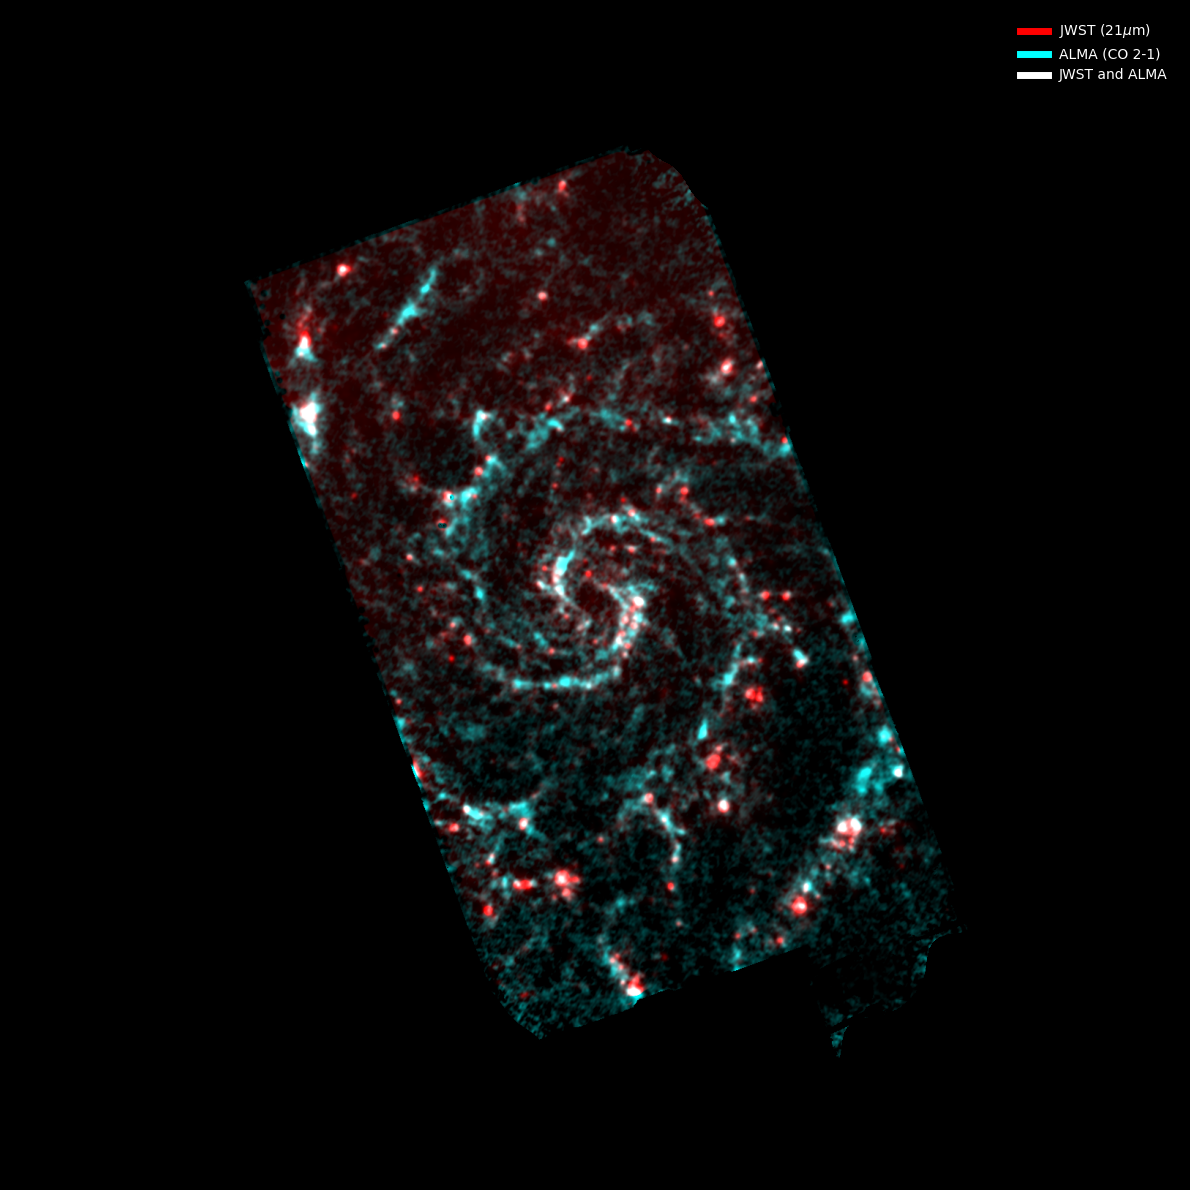

In [84]:
overlay_fits_images(jwst_convolved, image_data_phangs,
                        figsize=(15, 12), clip_percentile=99.5, vmin1=275, vmax1=287, vmin2=0, vmax2=20,label1='JWST (21$\mu$m)', label2='ALMA (CO 2-1)', label3='JWST and ALMA'
                    )

In [96]:
def display_three_images_with_overlay(image_data1, image_data2, xsize, ysize, 
                       flux_min1, flux_max1, flux_min2, flux_max2, 
                       show_north_arrow1=False, show_north_arrow2=False, show_north_arrow3=False,
                       show_scale_bar1=False, show_scale_bar2=False, show_scale_bar3=False,
                       pixel_scale1=None, pixel_scale2=None, pixel_scale3=None,
                       galaxy_distance_mpc1=None, galaxy_distance_mpc2=None, galaxy_distance_mpc3=None,
                       titles=None,
                       overlap_fraction=0.1,
                       color1='red', color2='cyan'):  
    """
    Display three images side by side with overlap: two original images and their overlay.
    
    Parameters:
    - image_data1, image_data2: Input image arrays
    - xsize, ysize: Figure size
    - flux_min/max: Color scaling parameters for each image
    - show_north_arrow: Whether to display north arrow for each image
    - show_scale_bar: Whether to display scale bar for each image
    - pixel_scale: Pixel scale for scale bar for each image
    - galaxy_distance_mpc: Galaxy distance for scale bar for each image
    - titles: Optional list of three titles for the images
    - overlap_fraction: How much the adjacent images should overlap (0-1)
    - color1, color2: Colors for the overlay image
    """
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    from matplotlib.colors import Normalize
    
    # Create figure without using GridSpec
    fig = plt.figure(figsize=(xsize*3, ysize))
    fig.patch.set_facecolor("black")
    
    # Calculate positions with overlap - explicitly set positions
    standard_width = 1/3  # Standard width for each panel
    panel_width = standard_width + overlap_fraction  # Each panel is wider
    
    # Create three axes with explicit positioning
    left_panel_pos = [0, 0, panel_width, 1]
    middle_panel_pos = [standard_width - overlap_fraction/2, 0, panel_width, 1]
    right_panel_pos = [2*standard_width - overlap_fraction, 0, panel_width, 1]
    
    ax1 = fig.add_axes(left_panel_pos)
    ax2 = fig.add_axes(middle_panel_pos)
    ax3 = fig.add_axes(right_panel_pos)
    
    # Make sure tight_layout doesn't override our manual positioning
    plt.tight_layout = lambda: None
    
    # Display first image
    ax1.imshow(image_data1, cmap='gist_heat', vmin=flux_min1, vmax=flux_max1)
    ax1.axis('off')
    
    # Display second image
    ax2.imshow(image_data2, cmap='magma', vmin=flux_min2, vmax=flux_max2)
    ax2.axis('off')
    
    # Create the overlay image for the third panel
    # Normalize the data
    norm1 = Normalize(vmin=flux_min1, vmax=flux_max1)
    norm2 = Normalize(vmin=flux_min2, vmax=flux_max2)
    
    norm_data1 = norm1(image_data1)
    norm_data2 = norm2(image_data2)
    
    # Create RGB image
    rgb = np.zeros((image_data1.shape[0], image_data1.shape[1], 3))
    
    # Assign each image to different color channels
    if color1 == 'red':
        rgb[:, :, 0] = norm_data1
    elif color1 == 'green':
        rgb[:, :, 1] = norm_data1
    elif color1 == 'blue':
        rgb[:, :, 2] = norm_data1
    elif color1 == 'cyan':
        rgb[:, :, 1] = norm_data1
        rgb[:, :, 2] = norm_data1
    elif color1 == 'magenta':
        rgb[:, :, 0] = norm_data1
        rgb[:, :, 2] = norm_data1
    elif color1 == 'yellow':
        rgb[:, :, 0] = norm_data1
        rgb[:, :, 1] = norm_data1
        
    if color2 == 'red':
        rgb[:, :, 0] = norm_data2
    elif color2 == 'green':
        rgb[:, :, 1] = norm_data2
    elif color2 == 'blue':
        rgb[:, :, 2] = norm_data2
    elif color2 == 'cyan':
        rgb[:, :, 1] = norm_data2
        rgb[:, :, 2] = norm_data2
    elif color2 == 'magenta':
        rgb[:, :, 0] = norm_data2
        rgb[:, :, 2] = norm_data2
    elif color2 == 'yellow':
        rgb[:, :, 0] = norm_data2
        rgb[:, :, 1] = norm_data2
    
    # Display overlay image in third panel
    ax3.imshow(rgb, origin='upper')
    ax3.axis('off')
    
    # Add titles if provided
    if titles:
        if len(titles) >= 3:
            ax1.set_title(titles[0], color='white', fontsize=30)
            ax2.set_title(titles[1], color='white', fontsize=30)
            ax3.set_title(titles[2], color='white', fontsize=30)
        elif len(titles) == 2:
            ax1.set_title(titles[0], color='white', fontsize=30)
            ax2.set_title(titles[1], color='white', fontsize=30)
            ax3.set_title("Overlay", color='white', fontsize=30)
    
    # Add North arrows
    if show_north_arrow1:
        arrow_x, arrow_y = 0.1, 0.2
        arrow_length = 0.15
        ax1.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                     xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                     arrowprops=dict(facecolor='white', width=4, headwidth=16, headlength=16),
                     color='white', fontsize=25, ha='center', va='bottom')
    
    if show_north_arrow2:
        arrow_x, arrow_y = 0.5, 0.2  # Center of the second panel
        arrow_length = 0.15
        ax2.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                     xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                     arrowprops=dict(facecolor='white', width=4, headwidth=16, headlength=16),
                     color='white', fontsize=25, ha='center', va='bottom')
    
    if show_north_arrow3:
        arrow_x, arrow_y = 0.9, 0.2  # Right side of third panel
        arrow_length = 0.15
        ax3.annotate('N', xy=(arrow_x, arrow_y), xycoords='axes fraction',
                     xytext=(arrow_x, arrow_y - arrow_length), textcoords='axes fraction',
                     arrowprops=dict(facecolor='white', width=4, headwidth=16, headlength=16),
                     color='white', fontsize=25, ha='center', va='bottom')
    
    # Function to add scale bar
    def add_scale_bar(ax, image_data, pixel_scale, galaxy_distance_mpc):
        kpc_in_arcsec = 1.0e-3 * (1.0 / galaxy_distance_mpc) * 206265
        kpc_in_pixels = kpc_in_arcsec / pixel_scale
        
        bar_length = kpc_in_pixels
        bar_x = 0.1 * image_data.shape[1]
        bar_y = 0.1 * image_data.shape[0]
        bar_height = image_data.shape[0] * 0.005
        
        rect = patches.Rectangle((bar_x, bar_y), bar_length, bar_height,
                                linewidth=1, edgecolor='white', facecolor='white')
        ax.add_patch(rect)
        
        ax.text(bar_x + bar_length/2, bar_y - 2*bar_height, '1 kpc',
                color='white', fontsize=25, ha='center', va='bottom')
    
    # Add scale bars
    if show_scale_bar1 and pixel_scale1 is not None and galaxy_distance_mpc1 is not None:
        add_scale_bar(ax1, image_data1, pixel_scale1, galaxy_distance_mpc1)
    
    if show_scale_bar2 and pixel_scale2 is not None and galaxy_distance_mpc2 is not None:
        add_scale_bar(ax2, image_data2, pixel_scale2, galaxy_distance_mpc2)
    
    if show_scale_bar3 and pixel_scale3 is not None and galaxy_distance_mpc3 is not None:
        # For the overlay, use parameters from the first image
        if pixel_scale3 is None:
            pixel_scale3 = pixel_scale1
        if galaxy_distance_mpc3 is None:
            galaxy_distance_mpc3 = galaxy_distance_mpc1
        add_scale_bar(ax3, image_data1, pixel_scale3, galaxy_distance_mpc3)
    
    # Try to add PSF circles if available
    try:
        # Function to add circle if not already defined
        def add_circle_to_axis(ax, x, y, radius=1.0):
            """Add a small white circle to a matplotlib axis."""
            circle = patches.Circle((x, y), radius=radius, 
                                    facecolor='none', 
                                    edgecolor='white', 
                                    linewidth=2,
                                    alpha=1.0)
            ax.add_patch(circle)
            
        # Check if jwst_fwhm_pixscale and phangs_fwhm_pixscale exist, otherwise use dummy values
        jwst_radius = jwst_fwhm_pixscale if 'jwst_fwhm_pixscale' in globals() else 5
        phangs_radius = phangs_fwhm_pixscale if 'phangs_fwhm_pixscale' in globals() else 10
        
        # Add circles
        add_circle_to_axis(ax1, x=600, y=1450, radius=jwst_radius)
        add_circle_to_axis(ax2, x=600, y=1450, radius=phangs_radius)
        add_circle_to_axis(ax3, x=600, y=1450, radius=jwst_radius)
        
        # Add PSF text
        ax1.text(600-105, 1450, 'PSF', color='white', fontsize=25, ha='center', va='center')
    except (NameError, TypeError):
        # Skip PSF circles if variables don't exist
        pass
    
    # Add color legend for overlay
    image1_label = titles[0] if titles and len(titles) > 0 else "Image 1"
    image2_label = titles[1] if titles and len(titles) > 1 else "Image 2"
    
    ax3.plot([0], [0], color=color1, linewidth=5, label=image1_label)
    ax3.plot([0], [0], color=color2, linewidth=5, label=image2_label)
    ax3.plot([0], [0], color='white', linewidth=5, label="Both")
    
    # Configure legend with white text
    legend = ax3.legend(loc='upper right')
    frame = legend.get_frame()
    frame.set_facecolor('black')
    frame.set_edgecolor('black')
    
    # Set legend text color to white
    for text in legend.get_texts():
        text.set_color('white')
    
    # Return the figure and axes
    return fig, (ax1, ax2, ax3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-21.153846153846153..34.682107092965225].


(<Figure size 2400x600 with 3 Axes>,
 (<Axes: title={'center': 'JWST'}>,
  <Axes: title={'center': 'PHANGS'}>,
  <Axes: title={'center': 'Overlay'}>))

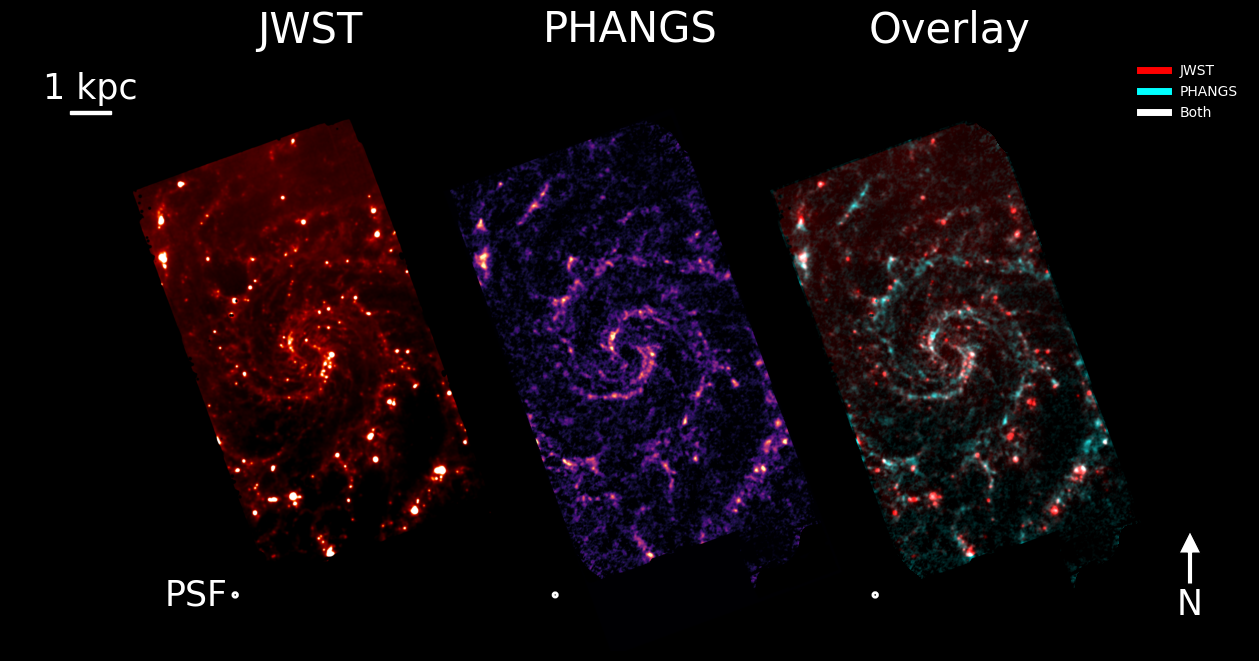

In [97]:
# Example usage
display_three_images_with_overlay(
    jwst_convolved, image_data_phangs, 
    xsize=8, ysize=6,
    flux_min1=275, flux_max1=288, 
    flux_min2=0, flux_max2=30,
    show_north_arrow1=False, show_north_arrow2=False, show_north_arrow3=True,
    show_scale_bar1=True, show_scale_bar2=False, show_scale_bar3=False,
    pixel_scale1=phangs_pixscale, pixel_scale2=phangs_pixscale, pixel_scale3=phangs_pixscale,
    galaxy_distance_mpc1=9.5, galaxy_distance_mpc2=9.5, galaxy_distance_mpc3=9.5,
    titles=["JWST", "PHANGS", "Overlay"],
    overlap_fraction=0.4, 
    color1='red', color2='cyan'
)